In [1]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import cv2
from multiprocessing import Process, Manager
%matplotlib inline

category_names = ['Bier', 'Bier Maß', 'Weißbier', 'Cola', 'Wasser', 'Curry-Wurst', 'Weißwein',
                   'A-Schorle', 'Jägermeister', 'Pommes', 'Burger', 'Williamsbirne', 'Alm-Breze', 'Brotzeitkorb',
                   'Käsespätzle']

In [2]:
"""
With this ipynb we evaluated our models closer. 
1. Plot the precision-recall curves
2. Plot the predicted bounding boxes
"""

# The parameters for the evaluation function
PATH_TO_FROZEN_GRAPH = '../pretrained/ssd_fpn.pb'
PATH_TO_FROZEN_GRAPH = '/nfs/students/winter-term-2018/project_2/final_files/models/ssd_fpn.pb'

GPU = '0'
RESIZE = (640, 640)
BATCH_SIZE = 2
DATA = 'evaluation_test_data.npz' # See CreateEvaluation.ipynb

In [3]:
def save_inference_for_batch(*args, **kwargs):
    """ Due to a unknown bug the inference might crash.
    This function evaluates the function run_inference_for_batch until it succeeds """
    ret_dict = Manager().dict()
    def run():
        try:
            ret = run_inference_for_batch(*args, **kwargs)
            ret_dict['ret'] = ret
        except:
            print('Exception during evaluation, retrying')
    while not 'ret' in ret_dict:
        p = Process(target=run)
        p.start()
        p.join()
    return ret_dict['ret']


def run_inference_for_batch(images, graph, batch_size):
    """
    this function runs inference on the images i.e. predicts the bounding boxes, etc.
    images: numpy array of images
    graph: the graph into which the model was loaded
    batch_size: the whole test set does not fit into memory
    returns the bounding boxes, the detected classes and the confidence scores for the images
    """
    with graph.as_default():
        with tf.Session() as sess:
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['detection_scores','detection_classes', 'detection_boxes']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
            ods = []
            for i in range(0, len(images), batch_size):
                ods.append(sess.run(tensor_dict, feed_dict={image_tensor: images[i:i+batch_size]}))
            output_dict = {k: np.concatenate([t[k] for t in ods]) for k in ods[0].keys()}
            output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int32) - 1
            return output_dict

def flatten_out_dict(output_dict):
    """ This function removes the first dimension from the arrays returned from run_inference_for_batch """
    return np.array(list(map(len, output_dict['detection_scores']))), output_dict['detection_scores'].flatten(), output_dict['detection_classes'].astype(np.int32).flatten()


In [4]:
# load the model into detection_graph
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [5]:
# load the test set and its labels
# limgs are the images i.e. this array is of shape (num_images, h, w, 3)
# gt contains the ground truth i.e. is of shape (num_images, num_classes)
# lmi is the x position of the left most bounding box. This is important to ensure that all objects of interest
# are still on the image when the aspect ratio is changed (e.g. from 16:9 to 1:1)
data = np.load(DATA)
limgs, gt, lmi = data['imgs'], data['gt'], data['lmi']
gt_copy = np.copy(gt)

In [6]:
# load and preprocess the test set images
w, h = RESIZE
imgs = np.zeros((len(limgs), h, w, 3), dtype=np.float32)
for i in range(len(imgs)):
    nw = int(limgs[i].shape[0] / h * w)
    m = min(limgs[i].shape[1] - nw, lmi[i])
    t = limgs[i, :, m:m+nw, :]
    imgs[i] = cv2.resize(t, (w, h))

# run inference i.e. predict the bounding boxes, etc.
out_dict = save_inference_for_batch(imgs, detection_graph, BATCH_SIZE)

# n references the image i.e. the ith bounding box belongs to the n[i]th image
# s is the confidence score
# c is the class prediction
n, s, c = flatten_out_dict(out_dict)
n = np.repeat(np.arange(len(n)), n)

# sort the predictions by their confidence score
sort_indices = np.argsort(s)[::-1]
n, s, c = n[sort_indices], s[sort_indices], c[sort_indices]

In [7]:
# recall-precision curve
rpg = np.empty((len(n)+2, 4))  # [recall, precision, threshhold, class]
tp, fp, fn = 0, 0, np.sum(gt)

# calculates the precision-recall curve
for i in range(len(n)):
    if gt[n[i]][c[i]] > 0:
        # if detection is correct
        tp += 1
        fn -= 1
        gt[n[i], c[i]] -= 1
    else:
        # if detection is incorrect
        fp += 1
    rpg[i] = tp / (tp + fn), tp / (tp + fp), s[i], c[i]

# ensure that the precision recall curve goes from 0 to 1
rpg[-2:, :] = [rpg[-3, 0]+1e-8, 0, 0, None], [1., 0., 0, None]
# smooth the precision recall curve
rpg[:, 1] = [np.max(rpg[i:, 1]) for i in range(len(rpg))]
# calculate the area under the curve
arpg = np.trapz(y=rpg[:, 1], x=rpg[:, 0])

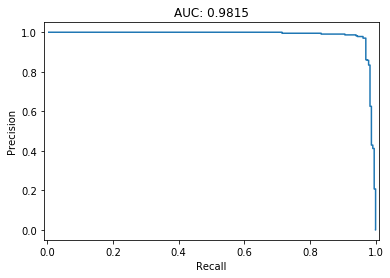

In [8]:
# plot the precision-recall curve
plt.plot(rpg[:, 0], rpg[:, 1])
plt.title('AUC: %.4f' % arpg)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([-0.01, 1.01, -.05, 1.05])
#plt.savefig('prc.png', dpi=150)
plt.show()

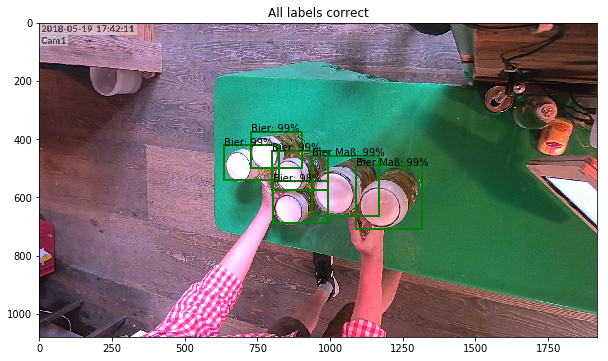

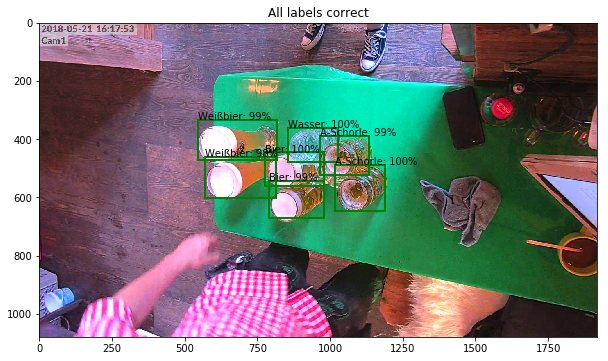

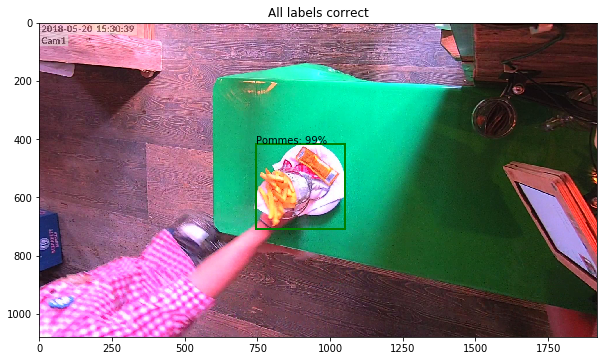

In [9]:
# plot the bounding boxes

# only plot the first n images
plot_n_images = 3

# confidence threshold
thresh = 0.8

for i in range(len(imgs)):
    if i >= plot_n_images:
        break
    bxs = out_dict['detection_boxes'][i]
    clss = out_dict['detection_classes'][i]
    scr = out_dict['detection_scores'][i]
    fig, ax = plt.subplots(1, figsize=(10, 10*h/w))
    ax.imshow(limgs[i] / 255)
    pred_classes = [0] * 15
    for j in range(len(bxs)):
        if scr[j] < thresh:
            continue
        pred_classes[int(clss[j])] += 1
        bx, by = bxs[j, 1] * 1080 + lmi[i], bxs[j, 0] * 1080
        bw, bh = (bxs[j, 3] - bxs[j, 1]) * 1080, (bxs[j, 2] - bxs[j, 0]) * 1080
        rect = patches.Rectangle((bx, by), bw, bh,linewidth=2, edgecolor='g',facecolor='none')
        ax.add_patch(rect)
        plt.text(bx, by, '%s: %.0f%%' % (category_names[int(clss[j])], scr[j]*100))
        #print('%s: %.4f' % (category_names[int(clss[j])], scr[j]))
    pred_classes = gt_copy[i] - pred_classes
    if all(p == 0 for p in pred_classes):
        plt.title('All labels correct')
    else: 
        plt.title('pred-gt: ' + ' | '.join(('%s %d' % (category_names[i], -pred_classes[i])) for i in range(len(pred_classes)) if pred_classes[i] != 0))
    plt.show()